In [63]:
import pandas as pd
import numpy as np

In [64]:
daily = pd.read_csv("Daily_Gold_Price_on_World.csv")
monthly = pd.read_csv("Monthly_Gold_Price_on_World.csv")
quarterly = pd.read_csv("Quarterly_Gold_Price_on_World.csv")

In [68]:
daily[daily.isna().any(axis=1)]
monthly[monthly.isna().any(axis=1)]
quarterly[quarterly.isna().any(axis=1)]

,Date,US dollar (USD),Euro (EUR),Japanese yen (JPY),Pound sterling (GBP),Canadian dollar (CAD),Swiss franc (CHF),Indian rupee (INR),Chinese renmimbi (CNY),Turkish lira (TRY),Saudi riyal (SAR),Indonesian rupiah (IDR),UAE dirham (AED),Thai baht THB),Vietnamese dong (VND),Egyptian pound (EGP),Korean won (KRW),Russian ruble (RUB),South African rand (ZAR),Australian dollar (AUD)


<AxesSubplot:xlabel='Date'>

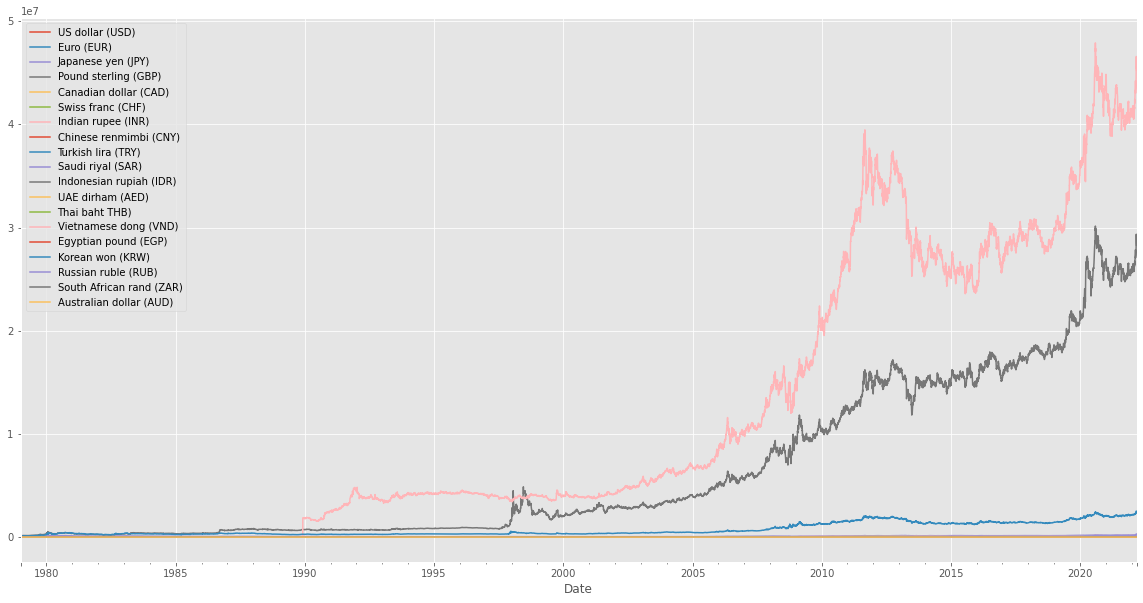

In [3]:
### Initial imports to get started.

import pandas as pd
import matplotlib.pylab as plt

%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

sales_data = pd.read_csv('Daily_Gold_Price_on_World.csv')
sales_data['Date']=pd.to_datetime(sales_data['Date'])
sales_data.set_index('Date', inplace=True)

sales_data.plot()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

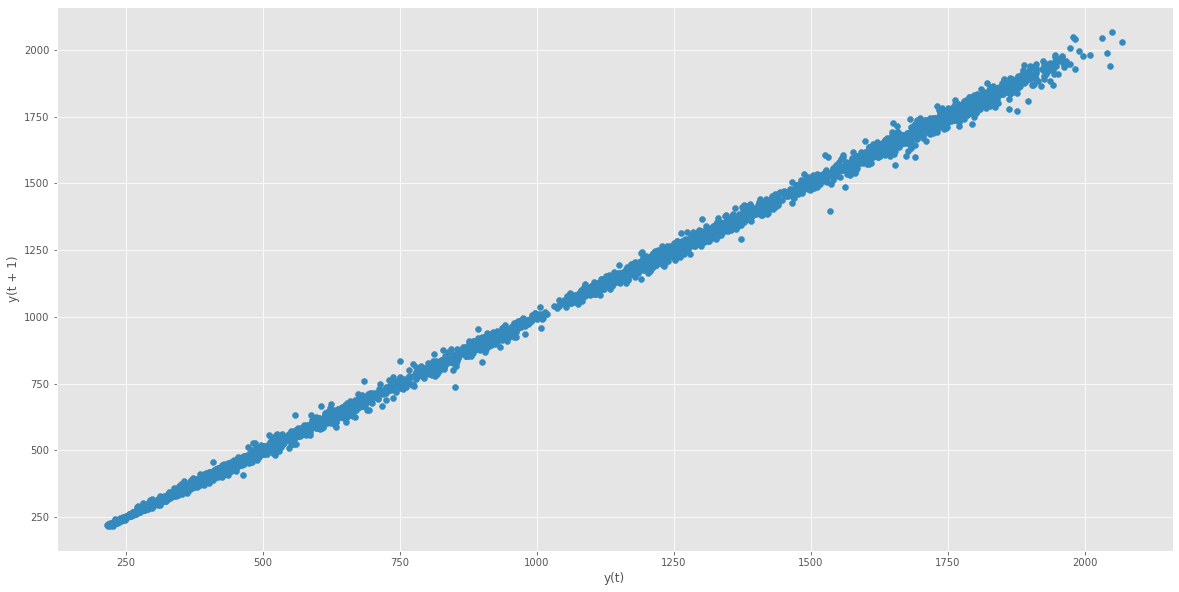

In [8]:
pd.plotting.lag_plot(sales_data['US dollar (USD)'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

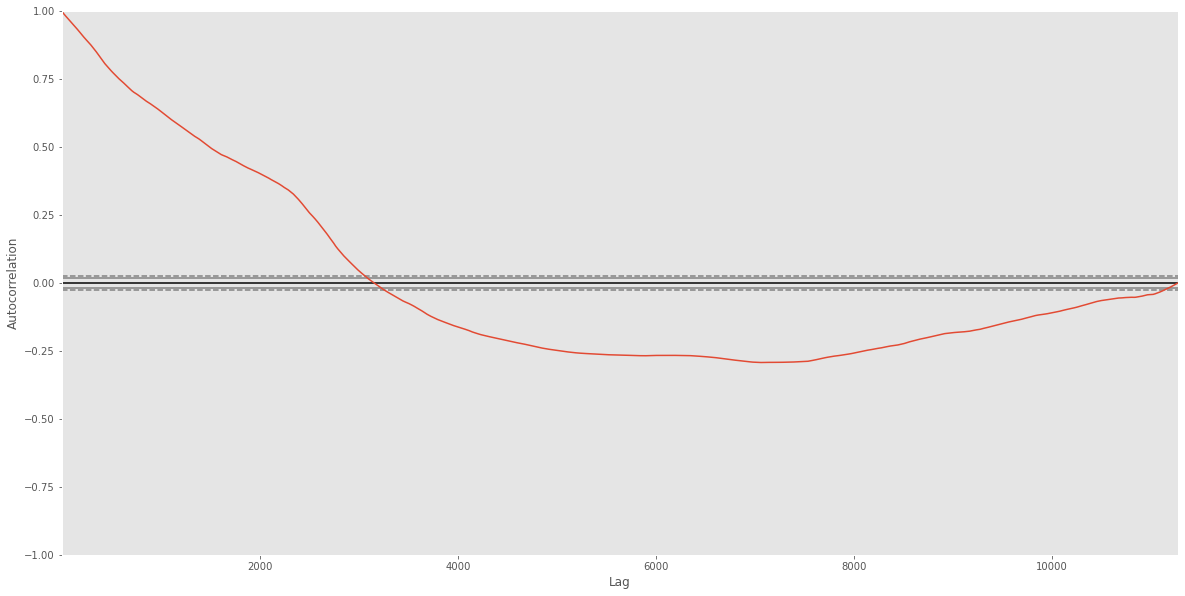

In [9]:
pd.plotting.autocorrelation_plot(sales_data['US dollar (USD)'])

In [1]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [4]:
adf_test(sales_data['US dollar (USD)'])

1. ADF :  0.6521376749210348
2. P-Value :  0.988832659639655
3. Num Of Lags :  40
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 11229
5. Critical Values :
	 1% :  -3.430932491362481
	 5% :  -2.861797429635493
	 10% :  -2.5669070246821484


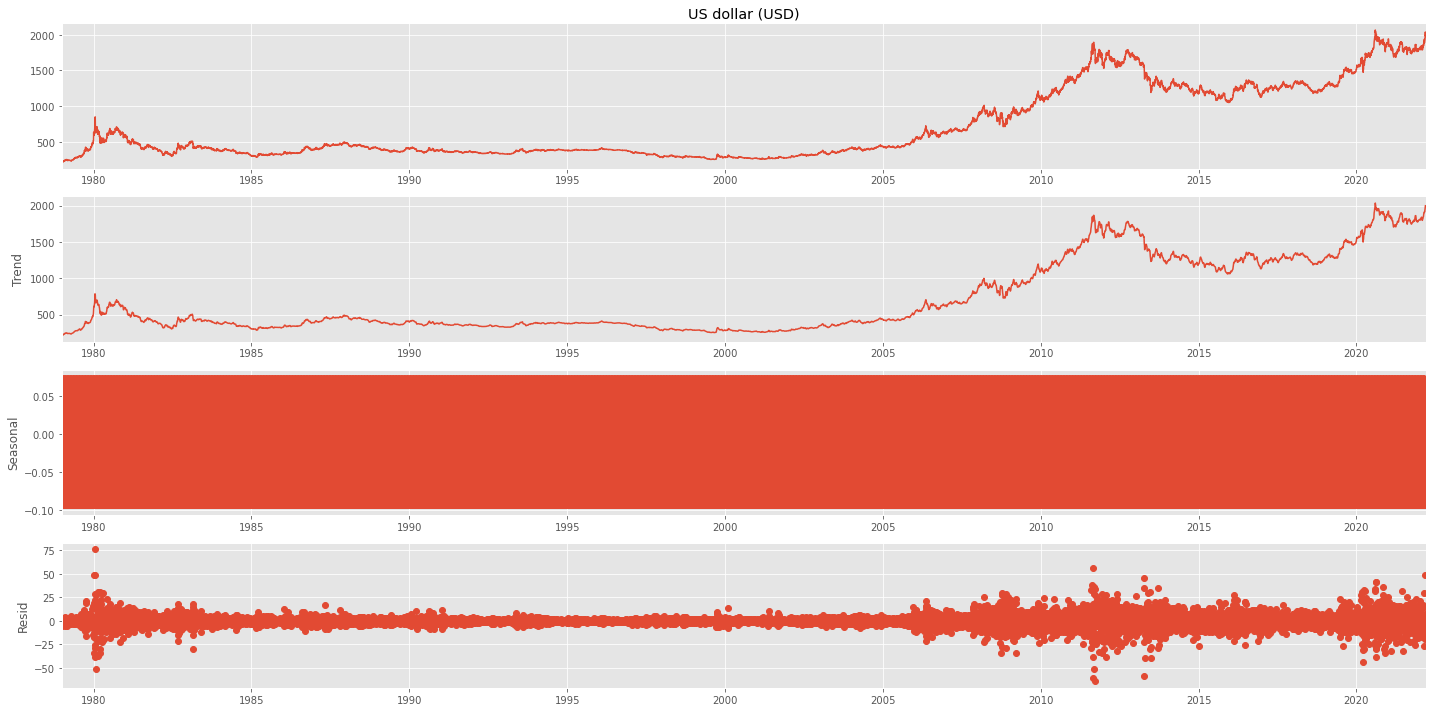

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(sales_data['US dollar (USD)'], model='additive')
x = decomposed.plot() #See note below about this

In [11]:
sales_data['stationary']=sales_data['US dollar (USD)'].diff()

Auto Regression

In [28]:
from statsmodels.tsa.ar_model import AutoReg

#create train/test datasets
X = sales_data['stationary'].dropna()
train_data = X[:len(X)-100]
test_data = X[len(X)-100:]

#train the autoregression model
model = AutoReg(train_data, lags=2)
model_fitted = model.fit()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


<AxesSubplot:>

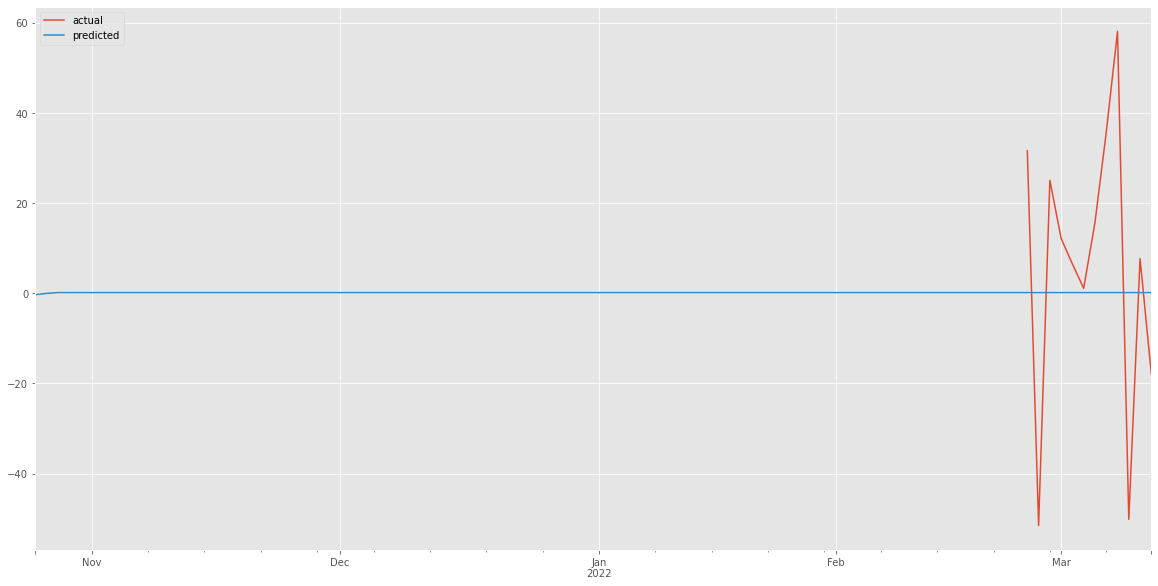

In [29]:
# make predictions 
predictions = model_fitted.predict(
    start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    dynamic=False)

# create a comparison dataframe
compare_df = pd.concat(
    [sales_data['stationary'].tail(12),
    predictions], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})

#plot the two values
compare_df.plot()

In [17]:
from sklearn.metrics import r2_score

r2 = r2_score(sales_data['stationary'].tail(100), predictions)

In [30]:
r2

-0.007461698944654316

In [37]:
import statsmodels, math
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error, mean_squared_error

In [39]:
details = {'Model':[],'RMSE':[],'MAPE':[],'MAE':[]}

Actual calculations 

In [40]:
T = sales_data['US dollar (USD)']

In [41]:

model = AutoReg(T.values[:11170], lags=2) # keep last 100 for validation
model_fit = model.fit()

In [43]:
yhat = model_fit.predict(start=11170,end=11269)
#print(yhat,len(yhat))

# This is forcast for most recent 100 days

# rmse = statsmodels.tools.eval_measures.rmse(usa.values[11170:],yhat)
mse = mean_squared_error(T.values[11170:],yhat)
print("The RMSE is:",math.sqrt(mse))

mape = mean_absolute_percentage_error(T.values[11170:],yhat)
print("The MAPE is:",mape)

mae = mean_absolute_error(T.values[11170:],yhat)
print("The MAE is:",mae)

details['Model'].append("Auto Regression")
details['RMSE'].append(math.sqrt(mse))
details['MAPE'].append(mape)
details['MAE'].append(mae)

The RMSE is: 56.385442460349374
The MAPE is: 0.02014297396581909
The MAE is: 37.917340653857735


In [44]:
next_20 = model_fit.predict(start=11269,end=11289)
print(next_20)

[1822.06322557 1822.20567146 1822.34811746 1822.49056357 1822.63300979
 1822.77545612 1822.91790257 1823.06034912 1823.20279579 1823.34524256
 1823.48768945 1823.63013645 1823.77258357 1823.91503079 1824.05747812
 1824.19992557 1824.34237313 1824.48482079 1824.62726857 1824.76971646
 1824.91216447]


ARIMA

In [45]:
!pip install pmdarima

In [46]:
import pmdarima as pm
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, 
                              start_p=3, 
                              start_q=3,
                              max_p=5,
                              max_q=5,
                              test="adf",
                              seasonal=True,
                              trace=True)
    return automodel

In [47]:
arimamodel(X)

Performing stepwise search to minimize aic
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=83244.913, Time=4.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=83252.115, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=83250.149, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=83250.096, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=83252.996, Time=0.04 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=83244.851, Time=2.69 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=83245.283, Time=2.24 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=83247.518, Time=1.92 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=83239.567, Time=4.89 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=83237.722, Time=1.99 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=83242.158, Time=0.79 sec
 ARIMA(1,0,5)(0,0,0)[0] intercept   : AIC=83239.466, Time=2.45 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=83251.969, Time=0.46 sec
 ARIMA(0,0,5)(0,0,0)[0] intercept   : AIC=83242.105, Time=0.94 sec
 ARIMA(2,0,5)(0,0,0

ARIMA(order=(1, 0, 4), scoring_args={}, suppress_warnings=True)

In [49]:
import statsmodels.api as sm

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


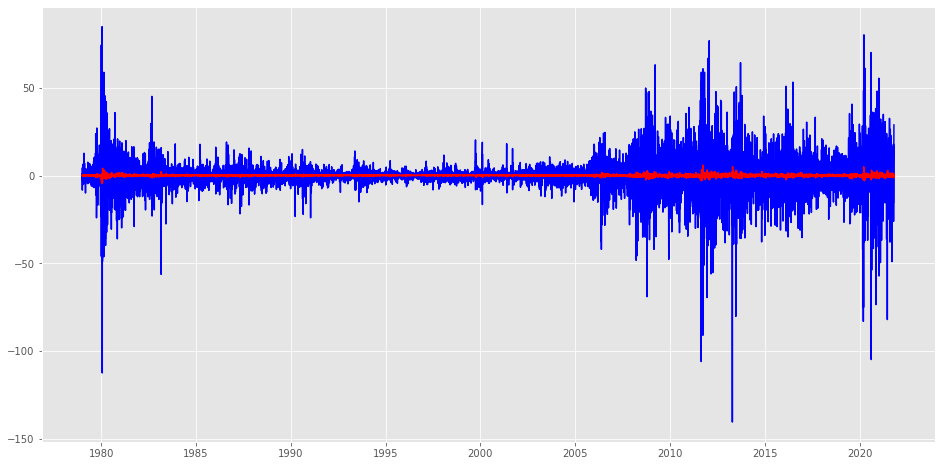

In [52]:
plt.figure(figsize=(16,8))
X.dropna(inplace=True)
B = X.dropna()
train = B[:len(B)-100]
test = B[len(B)-100:]
model = sm.tsa.arima.ARIMA(train, order=(1,0,4))  
results_ARIMA = model.fit()  
plt.plot(train, color="blue")
plt.plot(results_ARIMA.fittedvalues, color='red')

In [60]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(X, nlags=20)
lag_pacf = pacf(X, nlags=20)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


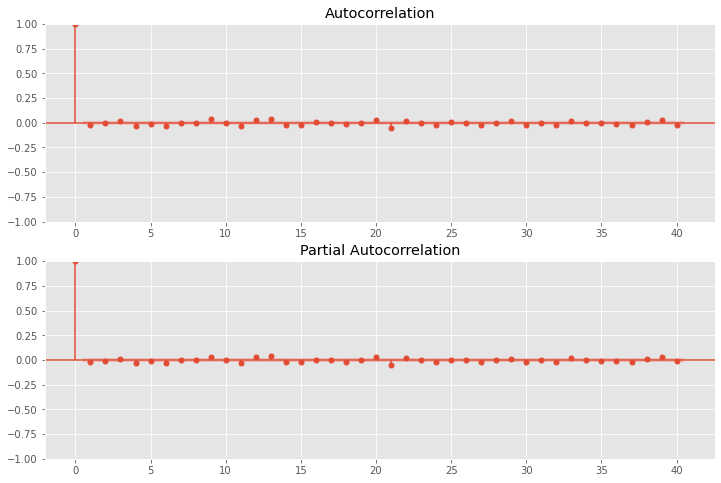

In [61]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X.dropna(),lags=40,ax=ax2)

In [54]:
model = sm.tsa.arima.ARIMA(T.values[:11170], order=(1,0,4))
model_fit = model.fit()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [58]:
# make prediction
yhat = model_fit.predict(start=11170,end=11269)
#print(yhat)

mse = mean_squared_error(T.values[11170:],yhat)
print("The RMSE is:",math.sqrt(mse))

mape = mean_absolute_percentage_error(T.values[11170:],yhat)
print("The MAPE is:",mape)

mae = mean_absolute_error(T.values[11170:],yhat)
print("The MAE is:",mae)

details['Model'].append("ARIMA")
details['RMSE'].append(math.sqrt(mse))
details['MAPE'].append(mape)
details['MAE'].append(mae)

The RMSE is: 65.49210789387799
The MAPE is: 0.022147674348088307
The MAE is: 41.90838802027968


In [62]:
next_20 = model_fit.predict(start=11269,end=11289)
print(next_20)

[1796.83098412 1796.73418289 1796.6373902  1796.54060603 1796.4438304
 1796.34706331 1796.25030474 1796.1535547  1796.05681319 1795.96008021
 1795.86335576 1795.76663983 1795.66993243 1795.57323355 1795.4765432
 1795.37986138 1795.28318807 1795.18652329 1795.08986703 1794.99321929
 1794.89658007]
